# Test custom visualizer

In [1]:
import tensorflow as tf
import pandas as pd
import importlib
import  numpy as np

# Set seed
tf.random.set_seed(42)

import custom_visualizer

## Load data

In [2]:
# Load dataloader
DATASET_PATH = "../processed_data/transformer_dataset"  # adjust if needed

ds = (tf.data.Dataset
      .load(DATASET_PATH)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE))

In [4]:
# Extract all the sequences from the test set (takes about 3 min)
from custom_visualizer import extract_subset_from_dataloader
test_sequences = extract_subset_from_dataloader(ds, k=None, split_id_filter=2) # 2 for test set
print(f"Number of sequences for test set: {len(test_sequences)}")
print("First sequence:")
test_sequences[0]

Number of sequences for test set: 89920
First sequence:


(<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2022091109,       2481,          2,          1]])>,
 <tf.Tensor: shape=(1, 100, 46), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.14858334, 0.64596623, 0.1505    , ..., 0.36435273,
          0.1115    , 0.44465292],
         [0.14675   , 0.6553471 , 0.14958334, ..., 0.36210132,
          0.11141667, 0.44465292]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
 array([[0.14491667, 0.6643527 , 0.14858334, 0.30731708, 0.12266666,
         0.4664165 , 0.125     , 0.38311446, 0.15683334, 0.27579737,
         0.14233333, 0.554409 

In [5]:
# Drop all sequences in which the first vector has all zeros
old_n = len(test_sequences)
test_sequences = [seq for seq in test_sequences if not np.all(seq[1].numpy()[0, 0] == 0)]
print(f"Number of sequences dropped: {old_n - len(test_sequences)}")
print(f"Number of sequences for test set after dropping all-zero sequences: {len(test_sequences)}")

Number of sequences dropped: 55888
Number of sequences for test set after dropping all-zero sequences: 34032


In [6]:
# Convert the sequences to a DataFrame
from custom_visualizer import covert_sequences_to_df
test_df = covert_sequences_to_df(test_sequences)

test_df.head()

,X,y,gameId,playId,frameId
0,"(((tf.Tensor(0.14858334, shape=(), dtype=float...","((tf.Tensor(0.082166664, shape=(), dtype=float...",2022091109,2481,1
1,"(((tf.Tensor(0.14675, shape=(), dtype=float32)...","((tf.Tensor(0.07958333, shape=(), dtype=float3...",2022091109,2481,2
2,"(((tf.Tensor(0.14491667, shape=(), dtype=float...","((tf.Tensor(0.077083334, shape=(), dtype=float...",2022091109,2481,3
3,"(((tf.Tensor(0.14316666, shape=(), dtype=float...","((tf.Tensor(0.074666664, shape=(), dtype=float...",2022091109,2481,4
4,"(((tf.Tensor(0.14141667, shape=(), dtype=float...","((tf.Tensor(0.072333336, shape=(), dtype=float...",2022091109,2481,5


In [7]:
# Get all the gameIds from the test set
gameIds = test_df['gameId'].unique()
print(f"Number of unique gameIds in the test set: {len(gameIds)}")
print(f"Unique gameIds: {gameIds}")

Number of unique gameIds in the test set: 5
Unique gameIds: [2022091109 2022091108 2022091107 2022091802 2022091900]


In [8]:
# Count the amount of frames per gameId and playId (transform)
test_df['frame_count'] = test_df.groupby(['gameId', 'playId'])['frameId'].transform('count')

# We have to add 100 to the frame count, because the last row has 100 frames in input plust the target
test_df['frame_count'] = test_df['frame_count'] + 100

# Value counts for count
print(test_df['frame_count'].value_counts())

test_df.head()

frame_count
190    720
178    702
186    688
168    680
161    671
      ... 
113     13
109      9
103      6
104      4
101      3
Name: count, Length: 137, dtype: int64


,X,y,gameId,playId,frameId,frame_count
0,"(((tf.Tensor(0.14858334, shape=(), dtype=float...","((tf.Tensor(0.082166664, shape=(), dtype=float...",2022091109,2481,1,170
1,"(((tf.Tensor(0.14675, shape=(), dtype=float32)...","((tf.Tensor(0.07958333, shape=(), dtype=float3...",2022091109,2481,2,170
2,"(((tf.Tensor(0.14491667, shape=(), dtype=float...","((tf.Tensor(0.077083334, shape=(), dtype=float...",2022091109,2481,3,170
3,"(((tf.Tensor(0.14316666, shape=(), dtype=float...","((tf.Tensor(0.074666664, shape=(), dtype=float...",2022091109,2481,4,170
4,"(((tf.Tensor(0.14141667, shape=(), dtype=float...","((tf.Tensor(0.072333336, shape=(), dtype=float...",2022091109,2481,5,170


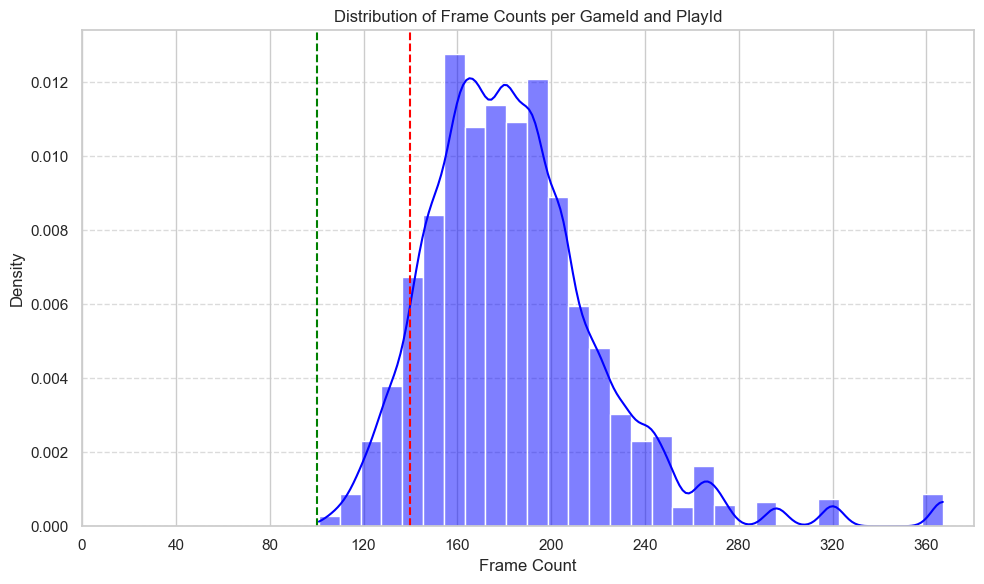

In [9]:
# Plot histogram of frame counts per gameId and playId
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a histogram of the frame counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df['frame_count'], bins=30, kde=True, color='blue', stat='density')
# Vertical line at 140
plt.axvline(x=140, color='red', linestyle='--', label='140 frames')
# Vertical line at 100
plt.axvline(x=100, color='green', linestyle='--', label='100 frames')
plt.title('Distribution of Frame Counts per GameId and PlayId')
plt.xlabel('Frame Count')
plt.ylabel('Density')
plt.xticks(ticks=range(0, test_df['frame_count'].max() + 1, 5))  # Set x-ticks to be integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure x-ticks are integers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Print the number of plays with at least 100 frames
print(f"Number of plays with at least 100 frames: {len(test_df[test_df['frame_count'] >= 100])}", "out of", len(test_df))
print(f"Number of plays with at least 140 frames: {len(test_df[test_df['frame_count'] >= 140])}", "out of", len(test_df))

Number of plays with at least 100 frames: 34032 out of 34032
Number of plays with at least 140 frames: 31350 out of 34032


In [11]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences)}")

play_sequences.head()

Selected playId: 2243
Number of sequences for playId 2243: 101


,X,y,gameId,playId,frameId,frame_count
12657,"(((tf.Tensor(0.84241664, shape=(), dtype=float...","((tf.Tensor(0.8345, shape=(), dtype=float32), ...",2022091107,2243,1,201
12658,"(((tf.Tensor(0.84241664, shape=(), dtype=float...","((tf.Tensor(0.8344167, shape=(), dtype=float32...",2022091107,2243,2,201
12659,"(((tf.Tensor(0.8423333, shape=(), dtype=float3...","((tf.Tensor(0.83425, shape=(), dtype=float32),...",2022091107,2243,3,201
12660,"(((tf.Tensor(0.8423333, shape=(), dtype=float3...","((tf.Tensor(0.8340833, shape=(), dtype=float32...",2022091107,2243,4,201
12661,"(((tf.Tensor(0.84225, shape=(), dtype=float32)...","((tf.Tensor(0.83391666, shape=(), dtype=float3...",2022091107,2243,5,201


## Testing

In [12]:
# Print the shape of one observation from train
# (try to get one of the last obsevations)
pct = 0.8
k = int(len(play_sequences) * pct)
print(f"Selected observation: {k}")

one_observation = play_sequences.iloc[k]

print("Shape of one observation from train set:", one_observation.shape)
print("Shape of the first column:", one_observation.iloc[0].shape)
print("Shape of the second column:", one_observation.iloc[1].shape)

# Look at the values from the columns
print("Values from the first column (ids):", one_observation.iloc[0].numpy())
print("Values from the second column (X):", one_observation.iloc[1].numpy())

Selected observation: 80
Shape of one observation from train set: (6,)
Shape of the first column: (1, 100, 46)
Shape of the second column: (1, 46)
Values from the first column (ids): [[[0.8348333  0.5587242  0.80116665 ... 0.6142589  0.79300004 0.55797374]
  [0.835      0.5585366  0.80116665 ... 0.6142589  0.79300004 0.55797374]
  [0.835      0.5585366  0.80116665 ... 0.6144465  0.79300004 0.55797374]
  ...
  [0.8858333  0.6273921  0.86766666 ... 0.50056285 0.7465833  0.27917448]
  [0.8850833  0.6272045  0.8670833  ... 0.48742965 0.7435834  0.2771107 ]
  [0.88416666 0.6270169  0.8665     ... 0.47429642 0.74016666 0.27579737]]]
Values from the second column (X): [[0.88325    0.62645406 0.86591667 0.52251405 0.8043333  0.5208255
  0.88475    0.5251407  0.506      0.47204503 0.7269167  0.27992496
  0.64925    0.7185741  0.78858334 0.57560974 0.67075    0.2836773
  0.73683333 0.2772983  0.8010833  0.5424015  0.846      0.51707315
  0.73475    0.23170732 0.7230833  0.2639775  0.6605     0.2

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

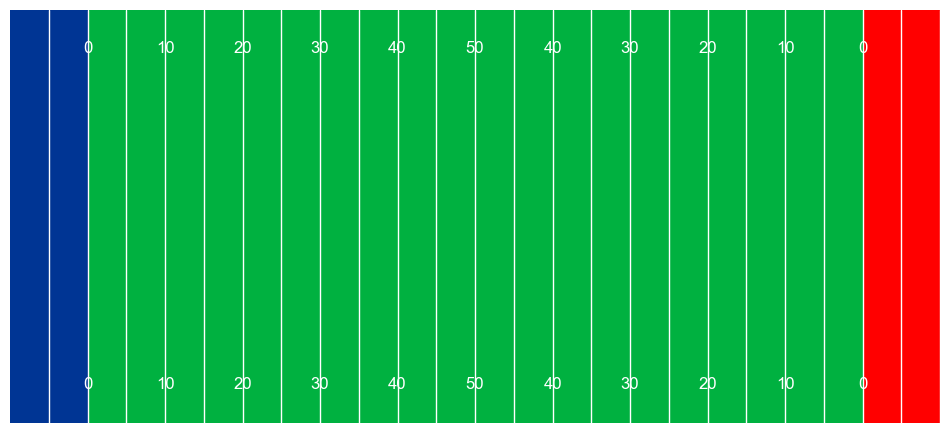

In [13]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

custom_visualizer.plot_pitch()

In [14]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to extract the trajectory of one player
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[0.7991667 , 0.59061915],
       [0.79925   , 0.59061915],
       [0.79925   , 0.59061915],
       [0.79933333, 0.59061915],
       [0.79933333, 0.5904315 ],
       [0.79941666, 0.59061915],
       [0.79941666, 0.59061915],
       [0.79941666, 0.59061915],
       [0.79941666, 0.59061915],
       [0.79941666, 0.59061915],
       [0.79941666, 0.5908068 ],
       [0.79941666, 0.5908068 ],
       [0.7995    , 0.59061915],
       [0.7995    , 0.59061915],
       [0.7995    , 0.5908068 ],
       [0.7995    , 0.5908068 ],
       [0.7995    , 0.5908068 ],
       [0.7995    , 0.5908068 ],
       [0.7995    , 0.5908068 ],
       [0.7995    , 0.5908068 ],
       [0.7995    , 0.5908068 ],
       [0.7995833 , 0.5908068 ],
       [0.7995833 , 0.5908068 ],
       [0.7995833 , 0.5908068 ],
       [0.79966664, 0.5908068 ],
       [0.79966664, 0.5908068 ],
       [0.79966664, 0.5908068 ],
       [0.79966664, 0.5908068 ],
       [0.79966664, 0.5908

In [15]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test descaling function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj = custom_visualizer.descale_trajectory(traj)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[ 95.9     ,  70.8743  ],
       [ 95.91    ,  70.8743  ],
       [ 95.91    ,  70.8743  ],
       [ 95.92    ,  70.8743  ],
       [ 95.92    ,  70.85178 ],
       [ 95.93    ,  70.8743  ],
       [ 95.93    ,  70.8743  ],
       [ 95.93    ,  70.8743  ],
       [ 95.93    ,  70.8743  ],
       [ 95.93    ,  70.8743  ],
       [ 95.93    ,  70.89681 ],
       [ 95.93    ,  70.89681 ],
       [ 95.94    ,  70.8743  ],
       [ 95.94    ,  70.8743  ],
       [ 95.94    ,  70.89681 ],
       [ 95.94    ,  70.89681 ],
       [ 95.94    ,  70.89681 ],
       [ 95.94    ,  70.89681 ],
       [ 95.94    ,  70.89681 ],
       [ 95.94    ,  70.89681 ],
       [ 95.94    ,  70.89681 ],
       [ 95.95    ,  70.89681 ],
       [ 95.95    ,  70.89681 ],
       [ 95.95    ,  70.89681 ],
       [ 95.96    ,  70.89681 ],
       [ 95.96    ,  70.89681 ],
       [ 95.96    ,  70.89681 ],
       [ 95.96    ,  70.89681 ],
       [ 95.96    ,  70.89

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

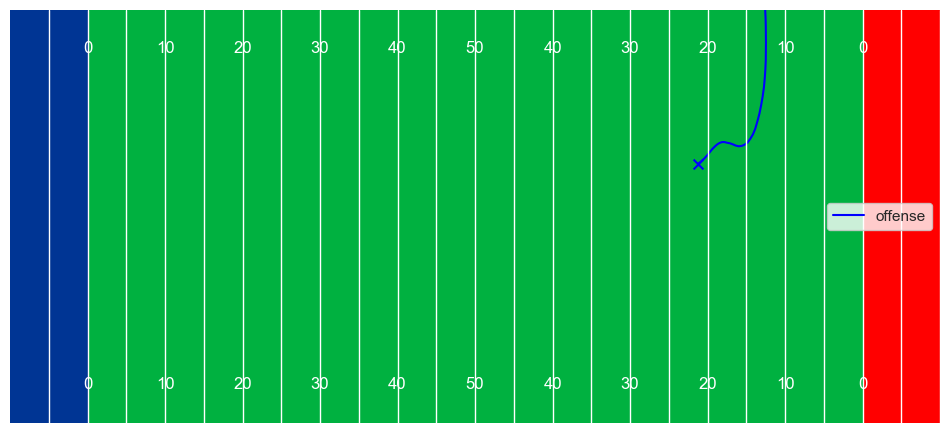

In [16]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='offense')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

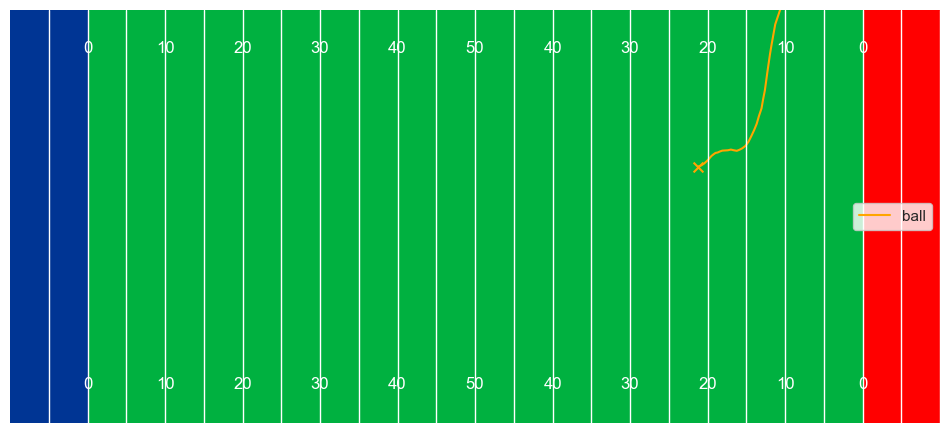

In [17]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, team='ball', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='ball')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

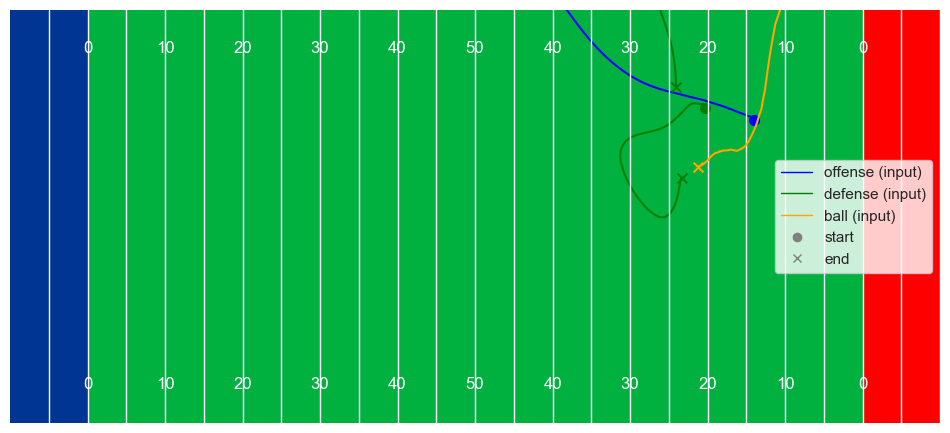

In [18]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense=[1,4], defense=[2,5], include_ball=True)

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

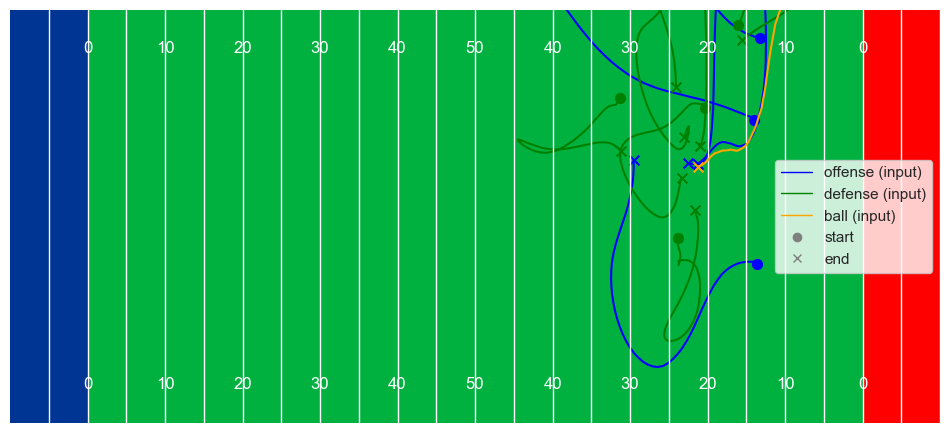

In [19]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense='all', defense='all', include_ball=True)

## Now full trajectories
Now let's try making a differnce between input, ground truth and predicted

In [20]:
from custom_visualizer import extract_full_sequence

In [21]:
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

(1, 201, 46)


(1, 201, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

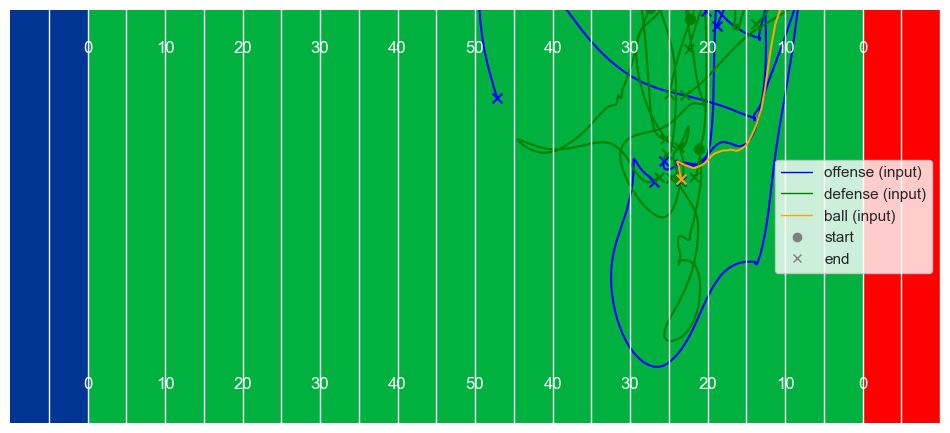

In [22]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)


Selected playId: 2849
Number of sequences for playId 2849: 59
(1, 159, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

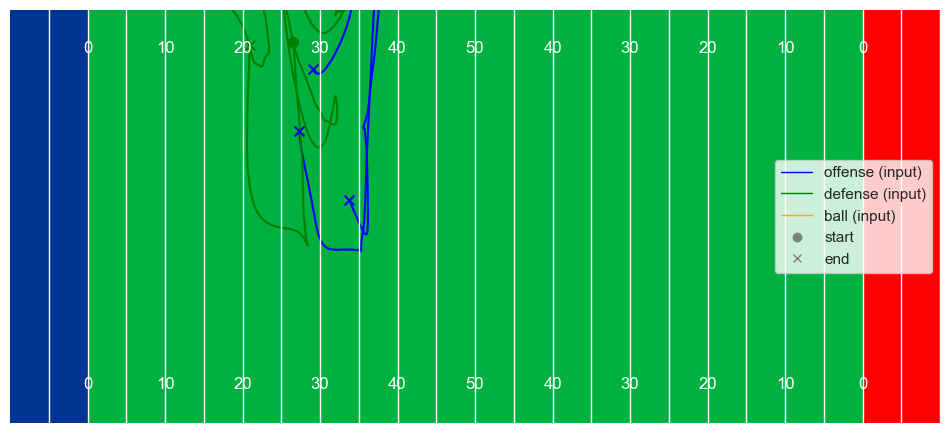

In [23]:
# Try a different play

# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)

Selected playId: 2541
Number of sequences for playId 2541: 85
(1, 185, 46)
(1, 85, 46)
First 2 values of first_X: tf.Tensor(
[[0.57475    0.53958726]
 [0.574      0.5393996 ]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.61125   0.5766417]
 [0.61125   0.5766417]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

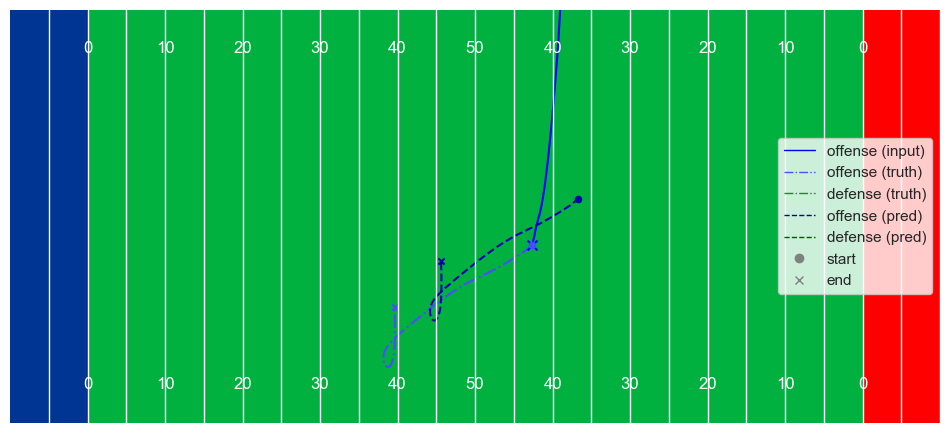

In [24]:
# Select the frames from one random playId with at least 140 frames
playId = 2541
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 3066
Number of sequences for playId 3066: 69
(1, 169, 46)
(1, 69, 46)
First 2 values of first_X: tf.Tensor(
[[0.6960833 0.5512195]
 [0.69675   0.5510319]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.77175003 0.58977485]
 [0.77175003 0.58977485]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

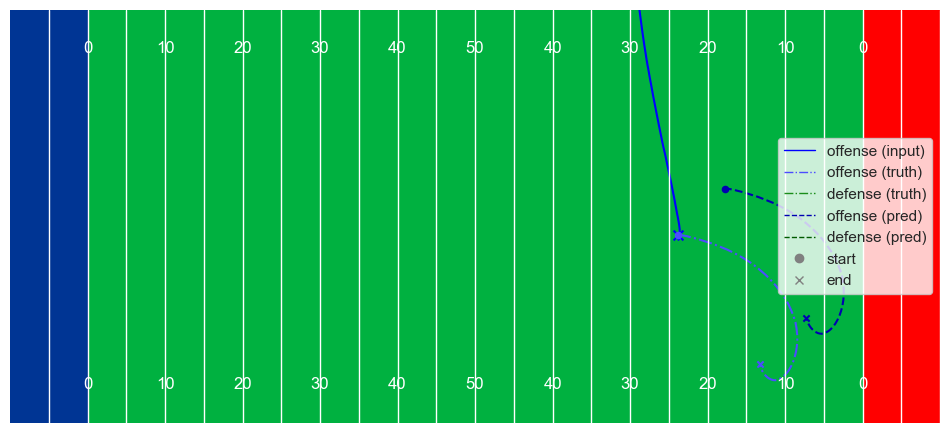

In [30]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 999
Number of sequences for playId 999: 128
(1, 228, 46)
First 2 values of first_X: tf.Tensor(
[[0.70316666 0.45572233]
 [0.7019167  0.45609757]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.6749164  0.45825362]
 [0.6642394  0.4684542 ]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

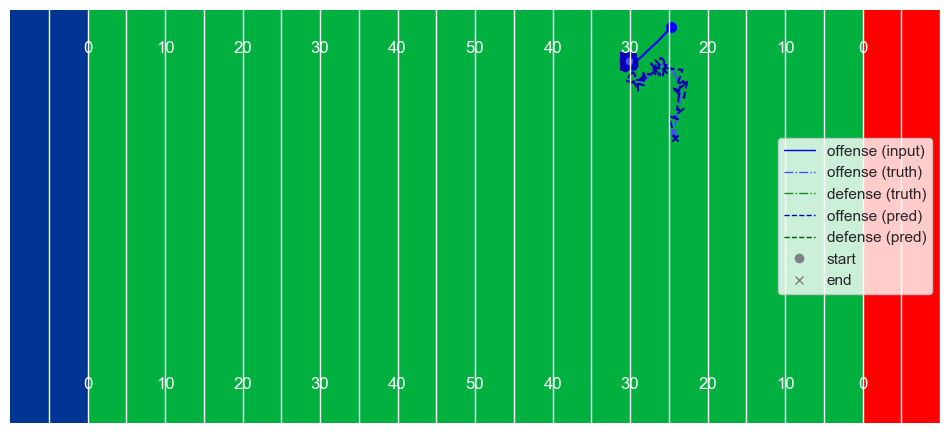

In [35]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Add very small random noise around zero
noise_scale = 0.01  # much smaller noise
noise = tf.random.uniform(subsequent_X.shape, minval=-noise_scale, maxval=noise_scale)

# Simulated prediction: ground truth + small noise
pred = subsequent_X + noise

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[1],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Predicted sequence shape: (1, 95, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

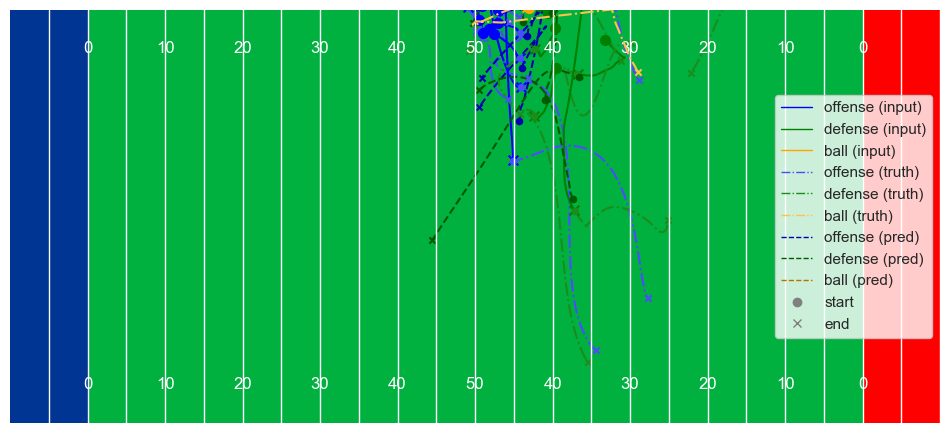

In [27]:
# ╔════════════════════════════════════════╗
# ║ 24. Load model, predict & visualize   ║
# ╚════════════════════════════════════════╝


import tensorflow as tf
import numpy as np
import custom_visualizer

# ── 1) Rolling‐window prediction helper ────────────────────────────────────────
def predict_future_sequence(model, seed_seq, horizon=40):
    """
    Roll a one‐step LSTM forward to predict `horizon` frames.
    seed_seq: (1, window_len, feature_dim) array or tensor
    Returns: (1, horizon, feature_dim) NumPy array
    """
    # ensure NumPy array
    seq = seed_seq.numpy() if isinstance(seed_seq, tf.Tensor) else seed_seq.copy()
    preds = []
    for _ in range(horizon):
        # predict one step
        yhat = model.predict(seq, verbose=0)        # (1, feature_dim)
        preds.append(yhat[0])                       # store (feature_dim,)
        # slide window: drop first, append prediction
        new_frame = yhat.reshape((1, 1, -1))        # (1,1,feature_dim)
        seq = np.concatenate([seq[:,1:,:], new_frame], axis=1)
    # stack into (1, horizon, feature_dim)
    return np.expand_dims(np.stack(preds, axis=0), axis=0)

# ── 2) Load trained model for inference ───────────────────────────────────────
model = tf.keras.models.load_model(
    "saved_models/lstm_position_only_best.keras",
    compile=False
)

# ── 3) Predict future frames for our selected play ────────────────────────────
# (first_X and subsequent_X were defined in the previous cell)
horizon = subsequent_X.shape[1]      # e.g. 40
pred_seq = predict_future_sequence(model, first_X, horizon=horizon)
print(f"Predicted sequence shape: {pred_seq.shape}")

# ── 4) Visualize past, ground truth & prediction ─────────────────────────────
custom_visualizer.plot_trajectories(
    sequence=first_X,                # known history
    ground_truth_seq=subsequent_X,   # true future frames
    pred_seq=pred_seq,               # predicted future frames
    offense='all',
    defense='all',
    include_ball=True
)


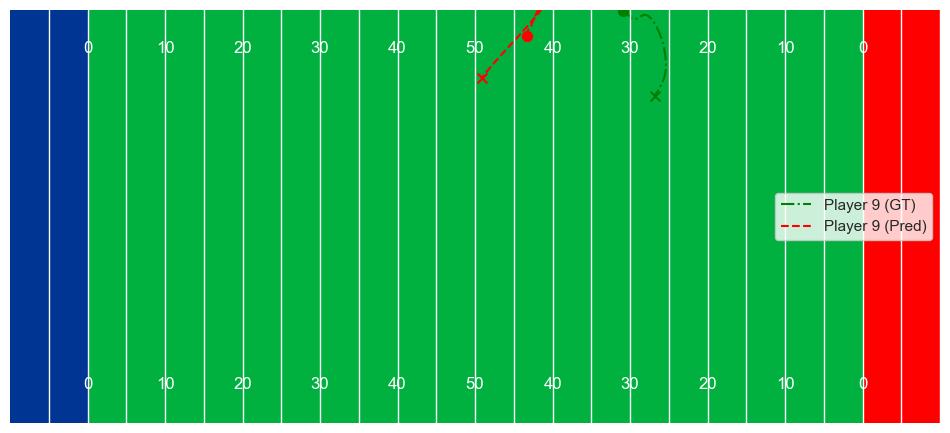

In [50]:
# ╔════════════════════════════════════════════╗
# ║ 25. Slice & Plot Single Player Trajectory ║
# ╚════════════════════════════════════════════╝

import matplotlib.pyplot as plt

# 1️⃣ Select which player (0–22) to visualize
player_idx = 9  # change this to any player index

# 2️⃣ Slice out that player’s (x,y) from ground truth and prediction
#    subsequent_X: true future frames tensor, shape (1, T, 46)
#    pred_seq:      predicted future frames array, shape (1, T, 46)
gt_player = subsequent_X[:, :, 2*player_idx : 2*player_idx + 2]  # shape (1, T, 2)
pred_player = pred_seq   [:, :, 2*player_idx : 2*player_idx + 2]

# 3️⃣ Descale back to field coordinates (yards)
gt_coords   = custom_visualizer.descale_trajectory(gt_player[0])
pred_coords = custom_visualizer.descale_trajectory(pred_player[0])

# 4️⃣ Plot pitch and overlay trajectories
fig, ax = custom_visualizer.plot_pitch()

# Ground-truth trajectory
custom_visualizer.plot_player_trajectory(
    gt_coords,
    ax=ax,
    traj_label=f"Player {player_idx} (GT)",
    traj_color="green",
    linestyle="-.",
    show_markers=True
)

# Predicted trajectory
custom_visualizer.plot_player_trajectory(
    pred_coords,
    ax=ax,
    traj_label=f"Player {player_idx} (Pred)",
    traj_color="red",
    linestyle="--",
    show_markers=True
)

plt.show()


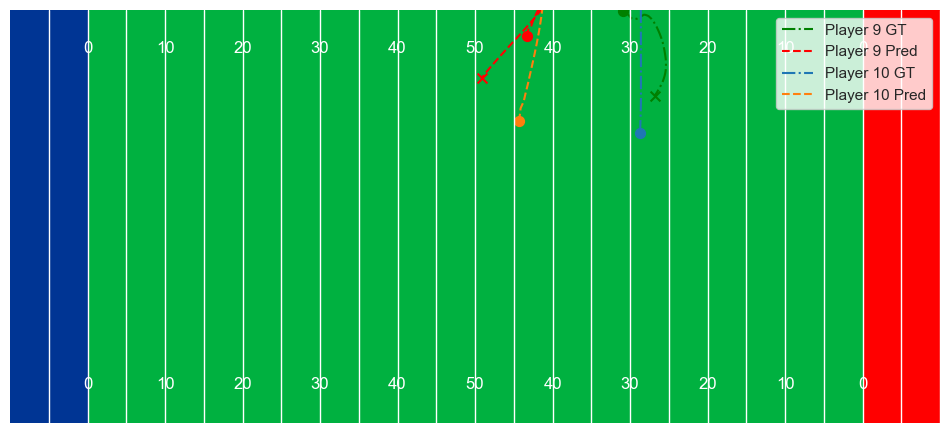

In [55]:
# ╔════════════════════════════════════════════════════╗
# ║ 26. Slice & Plot Multiple Player Trajectories    ║
# ╚════════════════════════════════════════════════════╝

import matplotlib.pyplot as plt

# 1️⃣ Specify which players to visualize (0–22)
player_indices = [9, 10]  # change these as needed

# 2️⃣ Define contrasting color pairs for each player: (GT_color, Pred_color)
color_pairs = [
    ("green", "red"),      # for player 1
    ("tab:blue", "tab:orange"),  # for player 7
    ("purple", "magenta")  # for player 8
]

# 3️⃣ Draw the pitch once
fig, ax = custom_visualizer.plot_pitch()

# 4️⃣ Loop over each player, slice their coords, descale, and plot
for (player_idx, (gt_color, pred_color)) in zip(player_indices, color_pairs):
    # slice out that player's x,y from true future and prediction
    gt_player   = subsequent_X [:, :, 2*player_idx : 2*player_idx + 2]  # (1, T, 2)
    pred_player = pred_seq     [:, :, 2*player_idx : 2*player_idx + 2]

    # descale to real field units
    gt_coords   = custom_visualizer.descale_trajectory(gt_player[0])
    pred_coords = custom_visualizer.descale_trajectory(pred_player[0])

    # ground-truth path (dash-dot), with start/end markers
    custom_visualizer.plot_player_trajectory(
        gt_coords,
        ax=ax,
        traj_label=f"Player {player_idx} GT",
        traj_color=gt_color,
        linestyle='-.',
        show_markers=True,
        marker_size=50
    )

    # predicted path (dashed), with start/end markers
    custom_visualizer.plot_player_trajectory(
        pred_coords,
        ax=ax,
        traj_label=f"Player {player_idx} Pred",
        traj_color=pred_color,
        linestyle='--',
        show_markers=True,
        marker_size=50
    )

# 5️⃣ Finalize and show legend
plt.legend(loc='upper right')
plt.show()
